In [1]:

import os

import pandas as pd

from logai.information_extraction.log_parser import LogParser, LogParserConfig
from logai.algorithms.parsing_algo.drain import DrainParams
from logai.preprocess.preprocess import Preprocessor, PreprocessorConfig
from logai.dataloader.data_model import LogRecordObject

In [5]:
# functions

def read_log(name):
    filepath = os.path.join(DIR, "{}.csv".format(name))

    with open(filepath, "r") as f:
        loglines = []
        cluster_labels = []
        pattern = ",{}`".format(name)
        for l in f.readlines():
            start_index = l.find(",{}`".format(name))
            if start_index != -1:
                logline = l[start_index:-1].replace(pattern, "")
                if logline:
                    loglines.append(logline.strip())
                    cluster_labels.append(l.split(",")[0])
    f.close()
    return loglines, cluster_labels

# read new ailtn
def read_new_ailtn():
    path = '/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/ailtn_with_label.csv'
    df = pd.read_csv(path, header=0)
    return df['_raw'], df['cluster_label']

# Levenshtein distance
import numpy as np
def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2

    a = 0
    b = 0
    c = 0

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if token1[t1-1] == token2[t2-1] \
                    or token1[t1-1] == "*" or token2[t2-1] == "*":
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]

                if a <= b and a <= c:
                    distances[t1][t2] = a + 1
                elif b <= a and b <= c:
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

def calc_distance(base, p):
    b_token = base.split(" ")
    p_token = p.split(" ")

    l = max(len(b_token), len(p_token))
    dis = levenshteinDistanceDP(b_token, p_token)
    sim = (l - dis) * 1.0 / l
    return dis, sim

def get_sim_table(parsed_loglines: pd.Series, lrt, cluster):
    pattern_counts = parsed_loglines.value_counts(normalize=True, sort=True, ascending=False).reset_index()
    pattern_counts.columns = ["pattern", "portion"]
    pattern_counts.sort_values(by="portion", ascending=False, inplace=True)
    base_pattern = pattern_counts["pattern"][0]

    similarity_table = []
    for index, row in pattern_counts.iterrows():
        pattern = row["pattern"]
        portion = row["portion"]
        dis, sim = calc_distance(base_pattern, pattern)
        similarity_table.append([lrt, cluster, portion, dis, sim, pattern, base_pattern])
    res = pd.DataFrame.from_dict(similarity_table)
    res.columns=["lrt", "cluster", "portion", "distance", "similarity", "pattern", "base_pattern"]
    return res, base_pattern

from logai.utils.functions import get_parameter_list


# read new ailtn
def read_new_logs(path):
    df = pd.read_csv(path, header=0, low_memory=False)
    res = df[['_raw', 'cluster_label']]
    res.columns = ['logline', 'cluster_label']
    return res

def parse_logs(loglines, cluster_label, lrt):
    drain_config = DrainParams(sim_th=0.1,                       extra_delimiters=[])
    log_parser_config = LogParserConfig(parsing_algorithm='drain',                              parsing_algo_params=drain_config)
    parser = LogParser(log_parser_config)
    parsed_result = parser.parse(loglines.dropna())
    parsed_result['cluster_label'] = cluster_label
    parsed_result['lrt'] = lrt
    return parsed_result


def cal_similarity_for_lrt(logs:pd.DataFrame, lrt):

    logrecord = LogRecordObject(body=logs['logline'], attributes=logs[['cluster_label']])
    similarity = pd.DataFrame()
    custom_delimeter_regex = [r"`+|\s+"]
    preprocessor = Preprocessor(PreprocessorConfig(custom_delimiters_regex=custom_delimeter_regex))
    preprocessed_loglines, _ = preprocessor.clean_log(logrecord.body)
    index_groups = preprocessor.group_log_index(logrecord.attributes, by=['cluster_label'])


    for i in index_groups.index:
        cluster_label = index_groups['cluster_label'].iloc[i]
        indices = index_groups['group_index'][i]
        if index_groups['cluster_label'].iloc[i] == -1:
            continue
        if len(indices) == 1:
            continue
        loglines_in_group = preprocessed_loglines.iloc[indices]
        parsed_result = parse_logs(loglines_in_group, cluster_label, lrt)

        uniq_patterns = parsed_result['parsed_logline'].unique()
        num_p = len(uniq_patterns)

        if num_p > 1:
            similarity_table, base_pattern = get_sim_table(parsed_result["parsed_logline"], lrt, cluster_label)
            similarity = similarity.append(similarity_table)

    return similarity



In [6]:
DIR = "/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/"

file_list = os.listdir(DIR)

similarity = pd.DataFrame()
parsing_res = pd.DataFrame()

base_patterns = pd.Series()
parameter_lists = pd.Series()

for file in file_list:
    path = os.path.join(DIR, file)
    name = file.split('_')[0]
    print(name)
    print(path)
    logs = read_new_logs(path)
    sim= cal_similarity_for_lrt(logs, name)
    similarity = similarity.append(sim)

/var/folders/gm/zf03v70n4ndcrg17spcgnrk80000gq/T/ipykernel_55738/2506712404.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  base_patterns = pd.Series()
/var/folders/gm/zf03v70n4ndcrg17spcgnrk80000gq/T/ipykernel_55738/2506712404.py:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  parameter_lists = pd.Series()


ailtn
/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/ailtn_with_label.csv
A
/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/A_with_label.csv
U
/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/U_with_label.csv
mqfrm
/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/mqfrm_with_label.csv
mqdbg
/Users/qcheng/workspace/gitsoma/logai/logai/data/sf_datasets_new_labels/mqdbg_with_label.csv


KeyboardInterrupt: 

In [ ]:
similarity.loc[(similarity["lrt"]== "ailtn") & (similarity["cluster"] == 233)]

In [18]:
RES_DIR = "/Users/qcheng/workspace/gitsoma/logai/logai/results/pattern_discovery/"

similarity.groupby("lrt").mean()[["distance", "similarity"]].to_csv(os.path.join(RES_DIR, "new_label_similarity.csv"))

<AxesSubplot:ylabel='Frequency'>

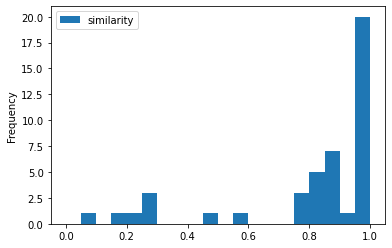

In [25]:
similarity[similarity['lrt'] == 'mqdbg'][['similarity']].plot.hist(bins=20, range=[0,1])